In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
  
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from jcopml.utils import save_model
from jcopml.plot import plot_missing_value
from luwiji.knn import demo, illustration

%matplotlib inline

### Import Data dan menghapus kolom

In [64]:
df = pd.read_csv("data/titanic.csv", index_col="PassengerId")
df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)

In [65]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,NaN,1,2,23.4500,S


### EDA (Exploratory Data Analysis)

#### Target

In [59]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### Numeric vs Target

C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


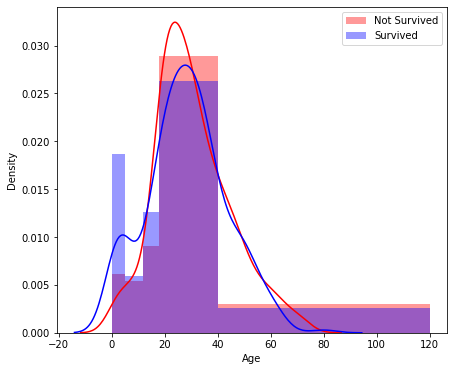

In [62]:
plt.figure(figsize=(7,6))
sns.distplot(df.Age[df.Survived==0], bins=[0,5,12,18,40,120], color='r', label="Not Survived")
sns.distplot(df.Age[df.Survived==1], bins=[0,5,12,18,40,120], color='b', label='Survived')
plt.legend();

C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


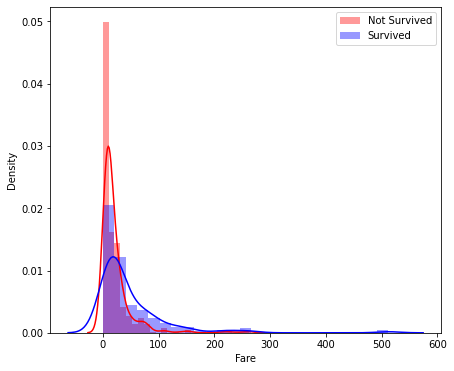

In [63]:
plt.figure(figsize=(7,6))
sns.distplot(df.Fare[df.Survived==0], bins=25, color='r', label="Not Survived")
sns.distplot(df.Fare[df.Survived==1], bins=25, color='b', label='Survived')
plt.legend();

#### Categoric/Ordinal vs Target

C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Juan\miniconda3\envs\quick_p1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

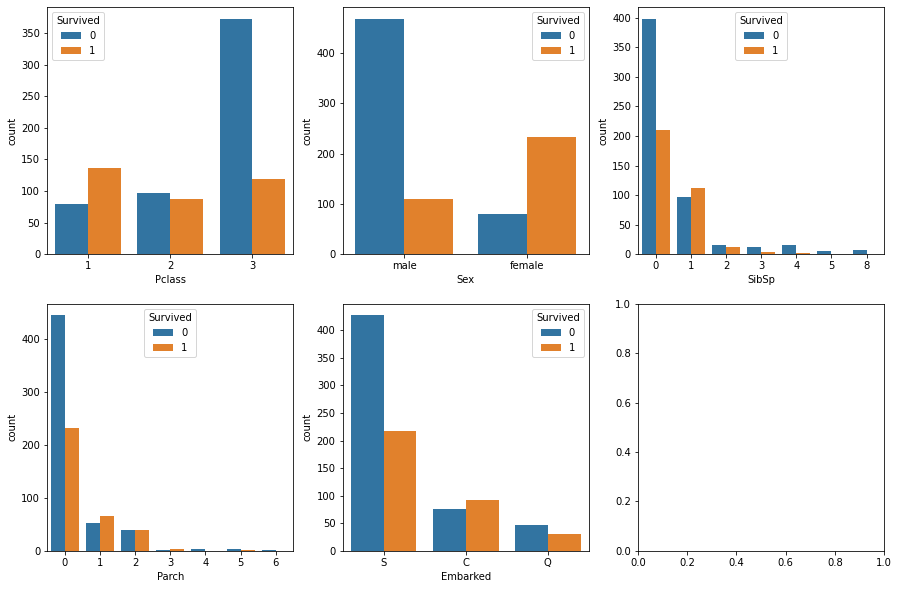

In [68]:
cat_var = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
fig, axes = plt.subplots(2,3, figsize=(15,10))

for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(cat, data=df, hue="Survived", ax=ax)

In [80]:
Pclass = pd.crosstab(df.Pclass, df.Survived, normalize="index")
Sex = pd.crosstab(df.Sex, df.Survived, normalize="index")
SibSp = pd.crosstab(df.SibSp, df.Survived, normalize="index")
Parch = pd.crosstab(df.Parch, df.Survived, normalize="index")
Embarked = pd.crosstab(df.Embarked, df.Survived, normalize="index")
Pclass

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


#### Feature Engineering

#####  Adding Feature => isAlone

In [82]:
df["isAlone"] = (df.SibSp ==0) & (df.Parch ==0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


#####  Binning

In [83]:
df.Age = pd.cut(df.Age, [0,5,12,18,40,120], labels=["balita", "anak-anak", "remaja", "dewasa", "lansia"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,S,False
2,1,1,female,dewasa,1,0,71.2833,C,False
3,1,3,female,dewasa,0,0,7.9250,S,True
4,1,1,female,dewasa,1,0,53.1000,S,False
5,0,3,male,dewasa,0,0,8.0500,S,True


##### Fare

In [84]:
df.Fare = pd.cut(df.Fare, [0,25, 100, 600], labels=["murah", "mahal", "eksekutif"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,murah,S,False
2,1,1,female,dewasa,1,0,mahal,C,False
3,1,3,female,dewasa,0,0,murah,S,True
4,1,1,female,dewasa,1,0,mahal,S,False
5,0,3,male,dewasa,0,0,murah,S,True


### Dataset Splitting

In [85]:
X = df.drop(columns="Survived")
y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

### Preprocessor

In [87]:
numerical_pipeline =Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, ["SibSp", "Parch"]),
    ("categoric", categorical_pipeline, ["Pclass", "Sex","Age", "Fare", "Embarked", "isAlone"])
])

In [ ]:
# #Alternative Code Preprocessor
# from jcopml.pipeline import num_pipe, cat_pipe

# preprocessor = ColumnTransformer([
#     ("numeric", num_pipe(scaling="minmax"), ["SibSp", "Parch"]),
#     ("categoric", cat_pipe(encoder="onehot"), ["Pclass", "Sex","Age", "Fare", "Embarked", "isAlone"])
# ])

### Pipeline

In [88]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier()), 
])

### Parameter Tuning

In [91]:
from jcopml.tuning import grid_search_params as gsp

In [93]:
# parameter = {
#     "algo__n_neighbors":range(1,51,2),
#     "algo__weights": ["uniform", "distance"],
#     "algo__p":[1,2] 
# }

model = GridSearchCV(pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['SibSp',
                                                                          'Parch']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                            

### Evaluation

In [94]:
print(model.best_params_)
print(model.score(X_train, y_train),model.best_score_, model.score(X_test, y_test))

{'algo__n_neighbors': 13, 'algo__p': 1, 'algo__weights': 'uniform'}
0.8328651685393258 0.817442588849886 0.770949720670391


### Prediction

In [ ]:
data = [
    [1, "female", 1, 1, 80, "S"],
    [3, "male", 0, 0, 5, "S"]
    ]
X_pred = pd.DataFrame(data, index=["Rose", "Jack"], columns=X.columns)
model.predict(X_pred)
X_pred["Survived"] = model.predict(X_pred)
X_pred

### Save Model

In [ ]:
save_model(model, 'knn_titanic.pkl')